# **Multi-Layer Perceptron (MLP) Classification**

## **Project Overview**

This notebook implements a Multi-Layer Perceptron (MLP) neural network from scratch for binary classification on a real-world banking dataset.

**Authors**: Rodrigo Medeiros, Matheus Castellucci, João Pedro Rodrigues

## **1. Dataset Selection**

### **Dataset Information**

**Name**: Binary Classification with a Bank Dataset  
**Source**: [Kaggle Playground Series S5E8](https://www.kaggle.com/competitions/playground-series-s5e8)  
**Original Dataset**: [Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing)  

**Size**:
- Training set: 750,000 rows × 18 columns
- Test set: 250,000 rows × 17 columns
- Features: 16 (7 numerical + 9 categorical)
- Target: Binary (subscription to term deposit: yes/no)

**Why this dataset?**
- Real-world banking application (predicting term deposit subscriptions)
- Sufficient complexity with mixed feature types
- Class imbalance - realistic scenario
- Relevant to marketing and customer behavior prediction

In [145]:
# Basic imports & reproducibility
import os
import random
from pathlib import Path
import warnings

import math
import numpy as np
import pandas as pd
import itertools
import copy

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# stats / util
from scipy import stats
from tqdm.auto import tqdm

# preprocessing & modeling
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

# metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score, classification_report
)

# notebook display
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
warnings.filterwarnings('ignore')

# plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('notebook')

# seeds for reproducibility (use consistently across notebook)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

## **2. Dataset Explanation**

In [146]:
# Load dataset
DATA_DIR = Path("data")
train = pd.read_csv(DATA_DIR / "train.csv")
test = pd.read_csv(DATA_DIR / "test.csv")

print("Dataset Shape:")
print(f"  Training: {train.shape}")
print(f"  Test: {test.shape}")

print("\nFirst 5 rows:")
display(train.head())

print("\nData Types:")
print(train.dtypes)

Dataset Shape:
  Training: (750000, 18)
  Test: (250000, 17)

First 5 rows:


,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1



Data Types:
id            int64
age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y             int64
dtype: object


### **Feature Descriptions**

**Numerical Features (7)**:
- `age`: Client's age
- `balance`: Average yearly balance (euros)
- `day`: Last contact day of month
- `duration`: Last contact duration (seconds)
- `campaign`: Number of contacts during this campaign
- `pdays`: Days since last contact from previous campaign (-1 = not contacted)
- `previous`: Number of contacts before this campaign

**Categorical Features (9)**:
- `job`: Type of job
- `marital`: Marital status
- `education`: Education level
- `default`: Has credit in default?
- `housing`: Has housing loan?
- `loan`: Has personal loan?
- `contact`: Contact communication type
- `month`: Last contact month
- `poutcome`: Outcome of previous campaign

**Target Variable**:
- `y`: Subscribed to term deposit? (0 = no, 1 = yes)

In [147]:
# Identify feature types
target_col = 'y'
id_col = 'id'

numerical_features = train.select_dtypes(include=['number']).columns.tolist()
numerical_features = [col for col in numerical_features if col not in [id_col, target_col]]

categorical_features = train.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical features ({len(numerical_features)}): {numerical_features}")
print(f"\nCategorical features ({len(categorical_features)}): {categorical_features}")

Numerical features (7): ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

Categorical features (9): ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


#### **Numerical Feature Summary**

In [148]:
# Summary statistics
display(train[numerical_features].describe())

print("\nTarget Variable Distribution:")
print(train[target_col].value_counts())
print(f"\nClass Balance: {train[target_col].value_counts(normalize=True)}")

,age,balance,day,duration,campaign,pdays,previous
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,40.926395,1204.067397,16.117209,256.229144,2.577008,22.412733,0.298545
std,10.098829,2836.096759,8.250832,272.555662,2.718514,77.319998,1.335926
min,18.000000,-8019.000000,1.000000,1.000000,1.000000,-1.000000,0.000000
25%,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000
50%,39.000000,634.000000,17.000000,133.000000,2.000000,-1.000000,0.000000
75%,48.000000,1390.000000,21.000000,361.000000,3.000000,-1.000000,0.000000
max,95.000000,99717.000000,31.000000,4918.000000,63.000000,871.000000,200.000000



Target Variable Distribution:
y
0    659512
1     90488
Name: count, dtype: int64

Class Balance: y
0    0.879349
1    0.120651
Name: proportion, dtype: float64


In [149]:
# Check for missing values
print("Missing Values:")
print(train.isnull().sum())

# Check for duplicates
print(f"\nDuplicate Rows: {train.duplicated().sum()}")

Missing Values:
id           0
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

Duplicate Rows: 0


In [150]:
# Check for outliers (beyond 3 standard deviations)
outlier_summary = {}
for col in numerical_features:
    z = np.abs(stats.zscore(train[col]))
    outlier_summary[col] = (z > 3).mean() * 100

outlier_df = pd.DataFrame.from_dict(outlier_summary, orient='index', columns=['% Outliers'])
display(outlier_df.sort_values('% Outliers', ascending=False))

,% Outliers
pdays,4.114667
campaign,2.006000
duration,1.752133
previous,1.625867
balance,1.238267
age,0.547867
day,0.000000


In [151]:
# Feature skewness
skewness = train[numerical_features].skew().sort_values(ascending=False)
print("Feature Skewness:")
display(skewness)

Feature Skewness:


previous    13.749885
balance     12.304123
campaign     4.810437
pdays        3.625049
duration     2.048776
age          0.586137
day          0.054014
dtype: float64

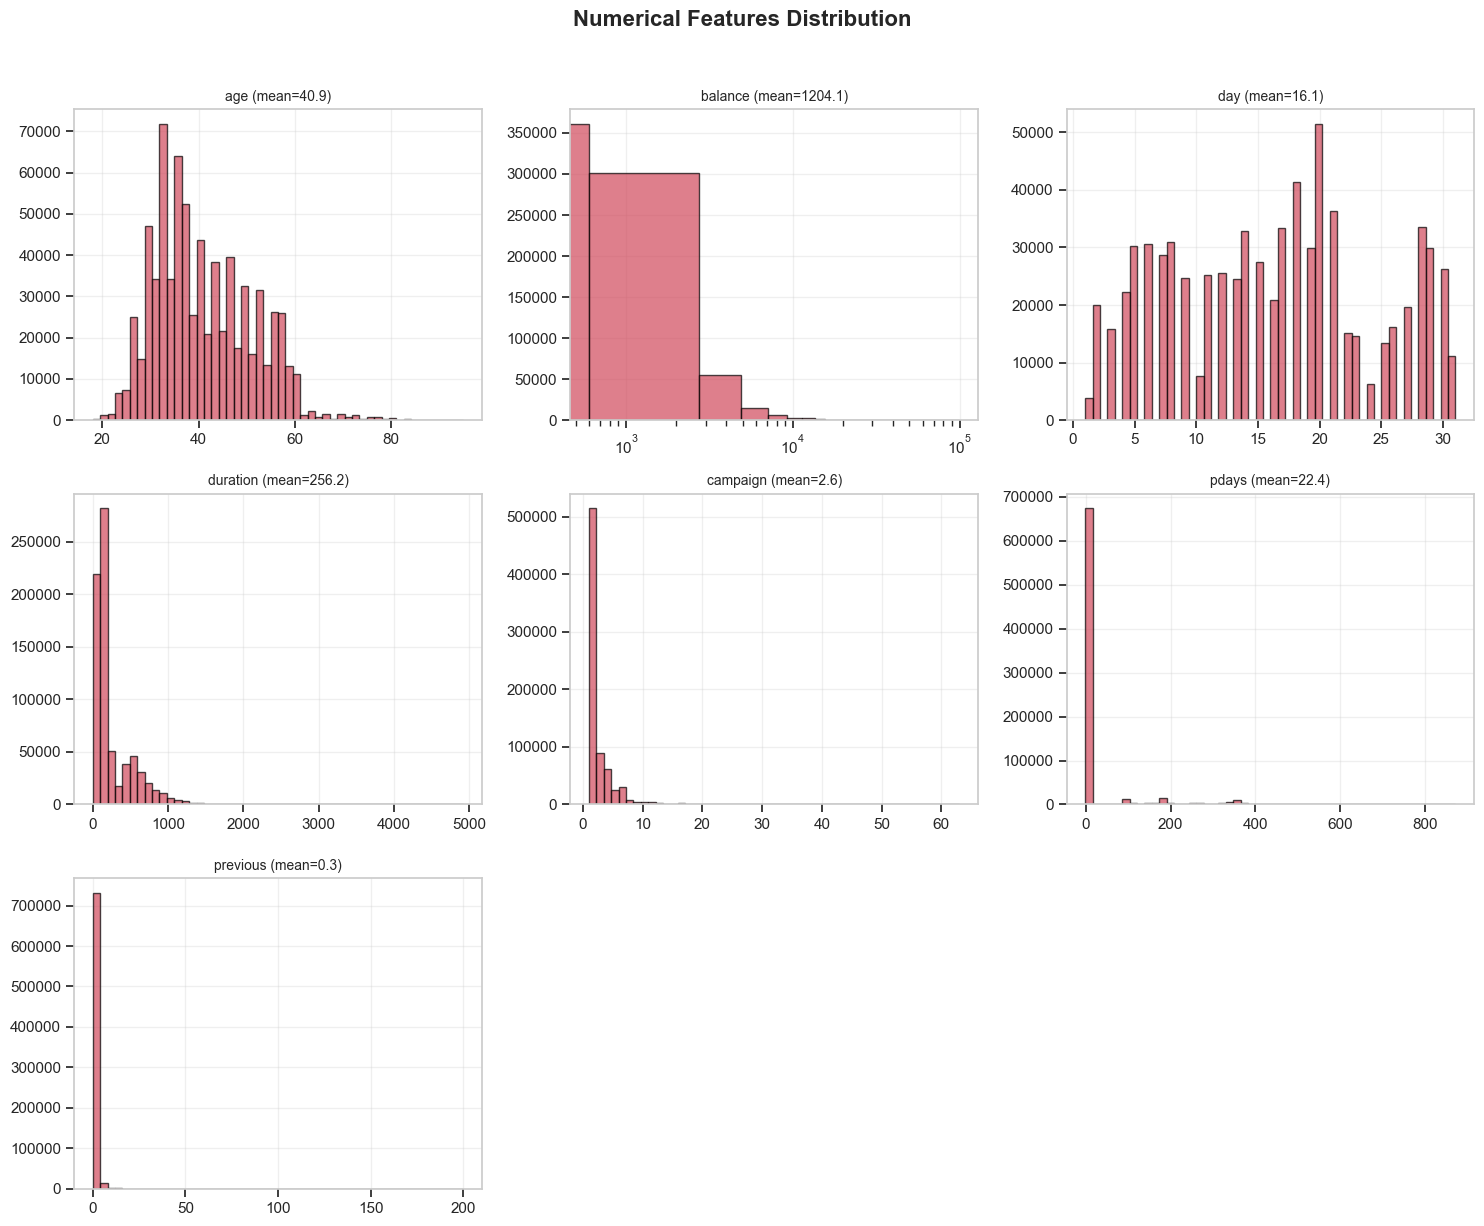

In [152]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(numerical_features):
    data = train[col].dropna()
    # histogram with density overlay (optional)
    axes[i].hist(data, bins=50, color="#d1495b", edgecolor="black", alpha=0.7)
    axes[i].set_title(f"{col} (mean={data.mean():.1f})", fontsize=10)
    axes[i].grid(alpha=0.3)
    if data.max() > 5000:
        axes[i].set_xscale("log")
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

fig.suptitle("Numerical Features Distribution", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

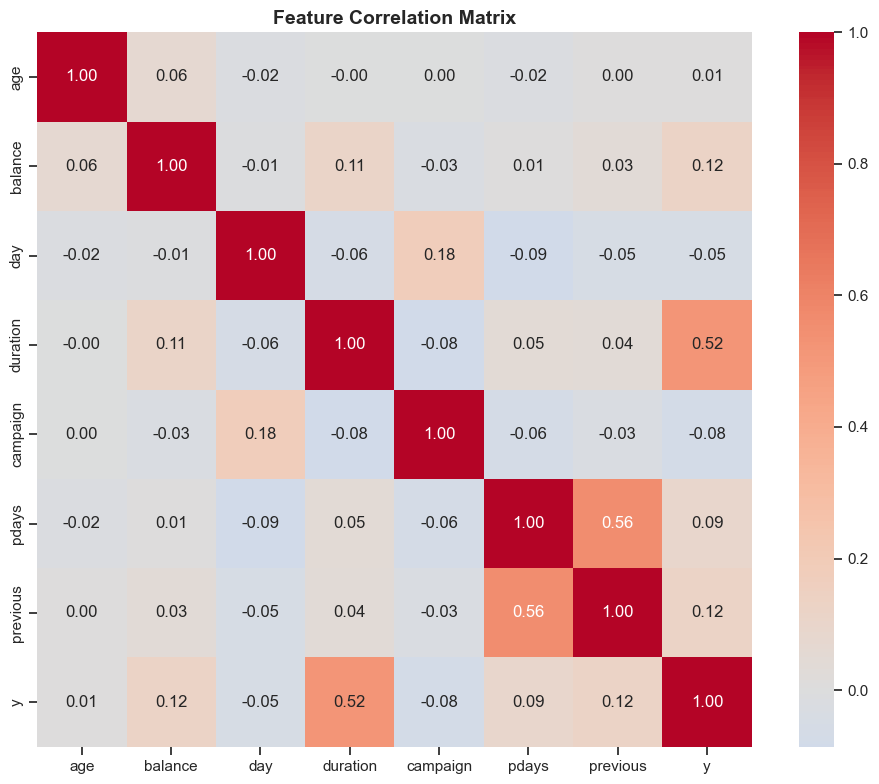


Most correlated features with target:
y           1.000000
duration    0.519283
balance     0.122513
previous    0.119552
pdays       0.089277
age         0.009523
day        -0.049625
campaign   -0.075829
Name: y, dtype: float64


In [153]:
# Correlation matrix
plt.figure(figsize=(10, 8))
correlation = train[numerical_features + [target_col]].corr()
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', center=0, square=True)
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nMost correlated features with target:")
print(correlation[target_col].sort_values(ascending=False))

#### **Categorical Feature Summary**

In [154]:
detailed = []
for c in categorical_features:
    vc = train[c].value_counts(dropna=False)
    top1 = f"{vc.index[0]}"
    detailed.append({
        'feature': c,
        'n_unique': train[c].nunique(dropna=False),
        'most_freq': top1,
        'total_rows': len(train)
    })
cat_summary_full = pd.DataFrame(detailed).set_index('feature')
display(cat_summary_full)

,n_unique,most_freq,total_rows
feature,,,
job,12,management,750000
marital,3,married,750000
education,4,secondary,750000
default,2,no,750000
housing,2,yes,750000
loan,2,no,750000
contact,3,cellular,750000
month,12,may,750000
poutcome,4,unknown,750000


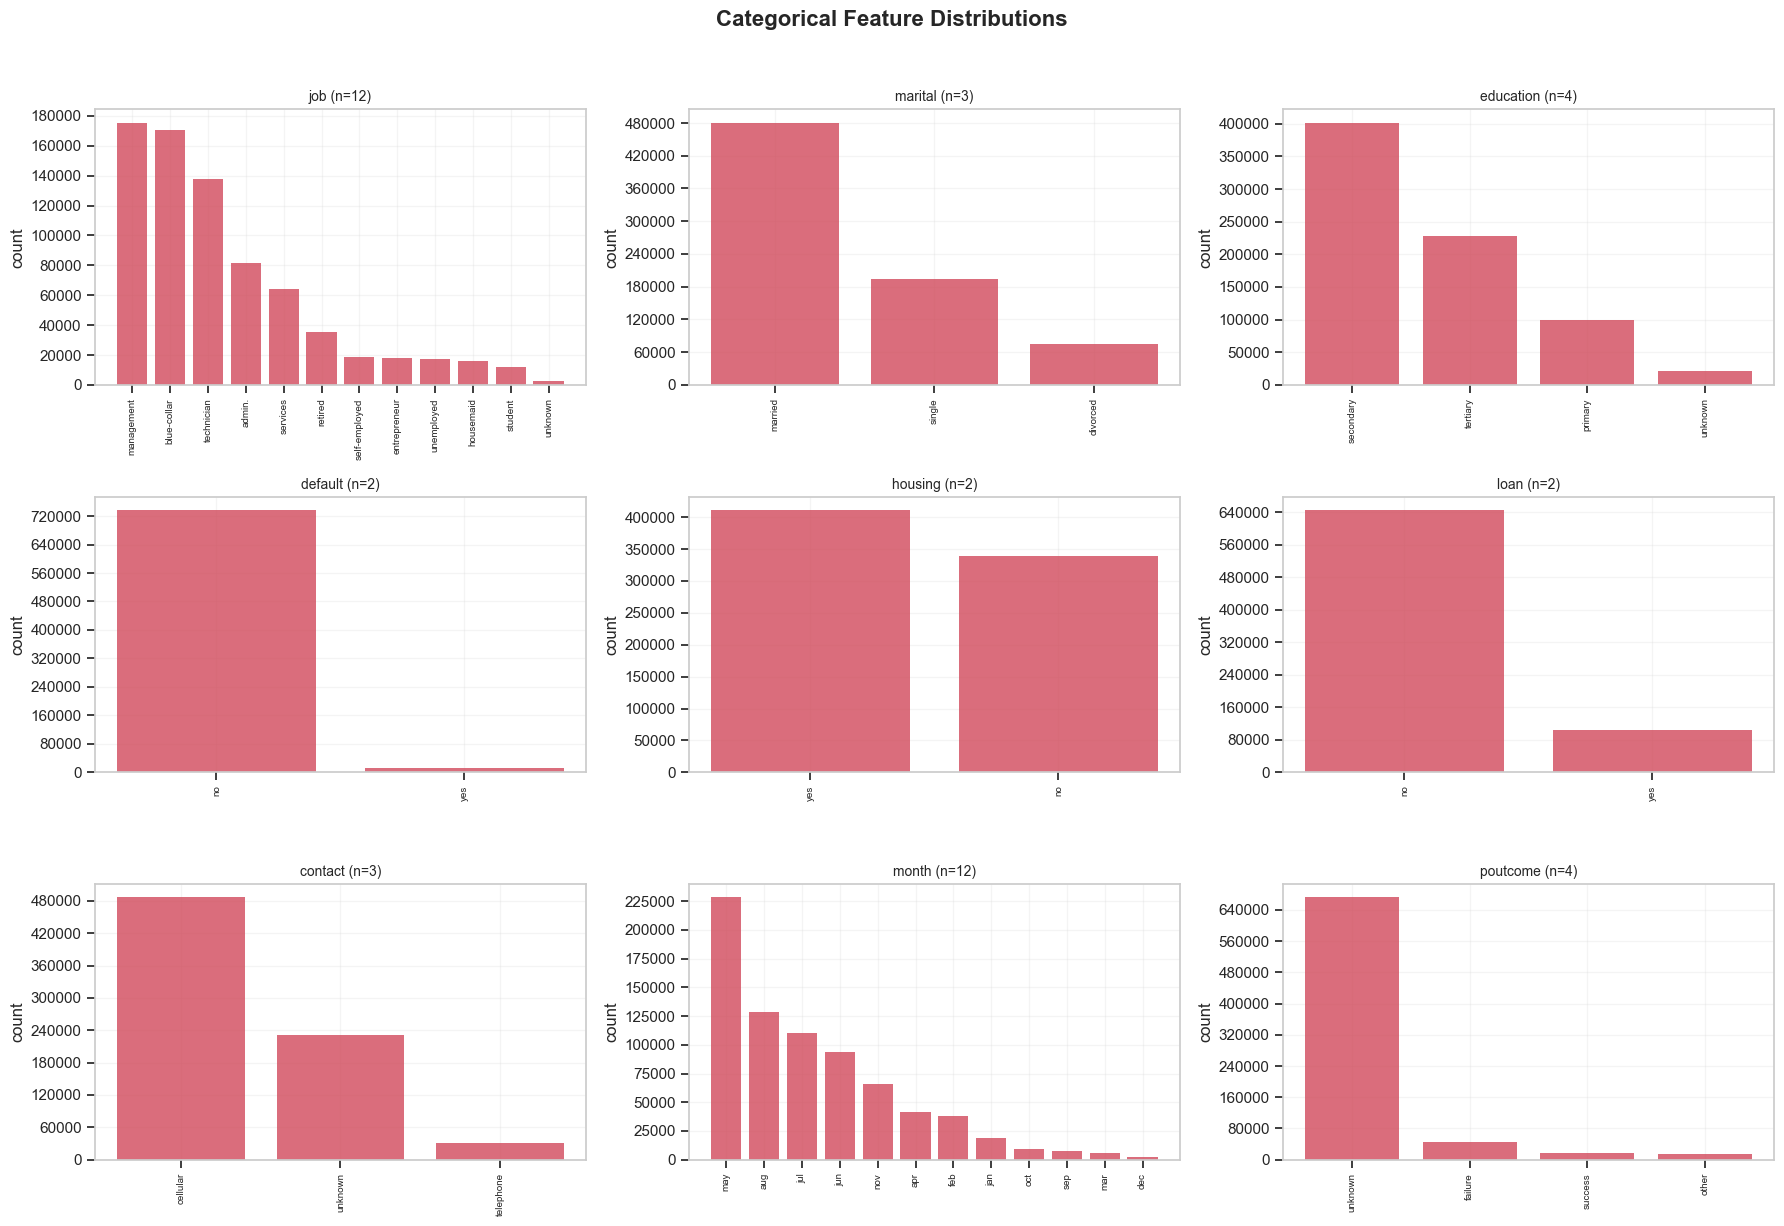

In [155]:
cat_cols = categorical_features
n_features = len(cat_cols)

# Choose subplot grid layout (3 columns works well)
cols = 3
rows = math.ceil(n_features / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4))
axes = axes.flatten()

for i, c in enumerate(cat_cols):
    ax = axes[i]
    vals = train[c].value_counts(dropna=False)
    categories = vals.index.astype(str).tolist()
    counts = vals.values

    # Compute target rate per category (align with counts)
    rates = train.groupby(c)[target_col].mean().reindex(vals.index).fillna(0).values

    # Plot count bars
    ax.bar(range(len(categories)), counts, alpha=0.8, color="#d1495b", label="count")

    ax.set_xticks(range(len(categories)))
    ax.set_xticklabels(categories, rotation=90, fontsize=7)
    ax.set_ylabel("count")
    ax.set_title(f'{c} (n={len(categories)})', fontsize=10)
    ax.grid(alpha=0.2)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

fig.suptitle("Categorical Feature Distributions", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

#### **Target Variable Distribution**

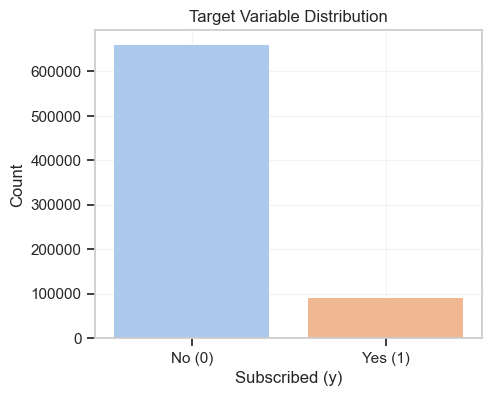

In [156]:
plt.figure(figsize=(5,4))
sns.barplot(x=train[target_col].value_counts().index, 
            y=train[target_col].value_counts().values, palette='pastel')
plt.title('Target Variable Distribution')
plt.xlabel('Subscribed (y)')
plt.ylabel('Count')
plt.xticks([0, 1], ['No (0)', 'Yes (1)'])
plt.grid(alpha=0.2)
plt.show()

### **Potential Issues Identified**

- **Class Imbalance**: ~88% negative class, ~12% positive class

- **Outliers**: Several numerical features have extreme values (detected via histograms)

- **Skewed Distributions**: Most numerical features are right-skewed

- **Mixed Feature Types**: Requires encoding for categorical variables

- **Missing Values**: No missing values detected

- **Duplicates**: No duplicate rows detected

## **3. Data Cleaning and Normalization**

In [157]:
# Cap outliers (1st/99th percentile)
train_work = train.copy()

for col in numerical_features:
    lower, upper = np.percentile(train_work[col], [1, 99])
    train_work[col] = np.clip(train_work[col], lower, upper)

In [158]:
# Handle skewness with log1p
# Replace -1 with 0 for pdays (no previous contact)
if "pdays" in train_work.columns:
    train_work["pdays"] = train_work["pdays"].replace(-1, 0)

# Automatically detect skewed columns (|skew| ≥ 1)
skewness = train_work[numerical_features].skew()
skewed_cols = skewness[skewness.abs() >= 1.0].index.tolist()
train_work[skewed_cols] = np.log1p(train_work[skewed_cols].clip(lower=0))

print(f"Highly skewed features transformed: {skewed_cols}")

Highly skewed features transformed: ['balance', 'duration', 'campaign', 'pdays', 'previous']


In [159]:
# Define features and target
X_full = train_work.drop(columns=[target_col, id_col])
y_full = train_work[target_col].values

In [160]:
# Split into train / val / test
# First split train+val vs test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_full, y_full, test_size=0.15, stratify=y_full, random_state=SEED
)
# Then split train vs val (from the remaining 85%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=SEED
)  # 0.1765 * 0.85 ≈ 0.15 → 70/15/15 overall

print("Final splits:")
print(f" Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(" Class balance (train):", np.bincount(y_train))
print(" Class balance (val):  ", np.bincount(y_val))
print(" Class balance (test): ", np.bincount(y_test))

Final splits:
 Train: (524981, 16), Val: (112519, 16), Test: (112500, 16)
 Class balance (train): [461642  63339]
 Class balance (val):   [98943 13576]
 Class balance (test):  [98927 13573]


In [161]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(drop="first", sparse_output=True, handle_unknown="ignore"), categorical_features),
    ],
    remainder="drop",
)

# Fit only on training data
preprocessor.fit(X_train)

# Transform splits
X_train_proc = preprocessor.transform(X_train)
X_val_proc   = preprocessor.transform(X_val)
X_test_proc  = preprocessor.transform(X_test)

print("\nProcessed feature dimensions:")
print(f" Train: {X_train_proc.shape}")
print(f" Val:   {X_val_proc.shape}")
print(f" Test:  {X_test_proc.shape}")


Processed feature dimensions:
 Train: (524981, 42)
 Val:   (112519, 42)
 Test:  (112500, 42)


In [162]:
# Class weights (for imbalance)
cw = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weight = {0: cw[0], 1: cw[1]}
print("\nClass weights:", class_weight)


Class weights: {0: np.float64(0.5686018603160025), 1: np.float64(4.144216043827657)}


#### **Preprocessing Justification**

- **Outlier Capping (1st–99th Percentile):** Limits the influence of extreme values while preserving all rows, avoiding bias and data loss.

- **Log Transform (|skew| ≥ 1):** Reduces heavy right skew in numerical features for more stable gradient updates.

- **StandardScaler:** Centers and scales numeric features to improve MLP convergence.

- **OneHotEncoder:** Encodes categorical variables as binary vectors; drop='first' prevents redundancy and handle_unknown='ignore' ensures consistency on new data.

- **Sparse Output:** Saves memory with large one-hot matrices, converted to dense only if needed for training.

- **Stratified 70/15/15 Split:** Preserves class proportions across train, validation, and test sets for unbiased evaluation.

- **Class Weights:** Counteracts class imbalance (~12% positive) by adjusting loss contributions between classes.

## **4. MLP Implementation**

In [163]:
class MLP:
    """
    Multi-Layer Perceptron (NumPy) for binary classification.
    Architecture: Input → Hidden Layer(s) → Output
    Activation: ReLU (hidden), Sigmoid (output)
    Loss: Binary Cross-Entropy with optional L2 regularization
    Optimizer: SGD (parameter updates handled externally)
    """
    
    def __init__(self, input_dim, hidden_sizes=[128, 64, 32], l2_lambda=1e-4, random_state=42):
        np.random.seed(random_state)
        self.l2_lambda = l2_lambda
        
        # Define layer sizes: input, hidden(s), output
        layer_sizes = [input_dim] + hidden_sizes + [1]
        self.num_layers = len(layer_sizes) - 1
        
        # Initialize parameters with He initialization (good for ReLU)
        self.weights = []
        self.biases = []
        for i in range(self.num_layers):
            n_in, n_out = layer_sizes[i], layer_sizes[i+1]
            std = np.sqrt(2.0 / n_in)
            self.weights.append(np.random.randn(n_in, n_out) * std)
            self.biases.append(np.zeros((1, n_out)))

    # Activation functions
    def relu(self, x):
        """ReLU activation"""
        return np.maximum(0, x)

    def relu_derivative(self, x):
        """Derivative of ReLU"""
        return (x > 0).astype(float)

    def sigmoid(self, x):
        """Numerically stable sigmoid"""
        out = np.empty_like(x)
        pos = x >= 0
        out[pos] = 1 / (1 + np.exp(-x[pos]))
        neg = ~pos
        exp_x = np.exp(x[neg])
        out[neg] = exp_x / (1 + exp_x)
        return out

    # Forward propagation
    def forward(self, X):
        """
        Forward pass through all layers.
        Returns:
            y_pred: predicted probabilities
            cache: activations for backpropagation
        """
        cache = {'A0': X}
        A = X
        for i in range(self.num_layers - 1):
            Z = A @ self.weights[i] + self.biases[i]
            A = self.relu(Z)
            cache[f'Z{i+1}'] = Z
            cache[f'A{i+1}'] = A
        Z_out = A @ self.weights[-1] + self.biases[-1]
        A_out = self.sigmoid(Z_out)
        cache[f'Z{self.num_layers}'] = Z_out
        cache[f'A{self.num_layers}'] = A_out
        return A_out, cache

    # Loss computation
    def compute_loss(self, y_true, y_pred):
        """
        Binary Cross-Entropy + optional L2 penalty.
        """
        m = y_true.shape[0]
        y_true = y_true.reshape(-1, 1)
        y_pred = np.clip(y_pred, 1e-12, 1 - 1e-12)
        bce = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        l2 = sum(np.sum(W**2) for W in self.weights) * (self.l2_lambda / (2 * m))
        return bce + l2

    # Backpropagation
    def backward(self, cache, y_true):
        """
        Compute gradients for all parameters using backpropagation.
        """
        y_true = y_true.reshape(-1, 1)
        m = y_true.shape[0]
        grads_w, grads_b = [], []

        # Gradient for output layer
        y_pred = cache[f'A{self.num_layers}']
        dZ = y_pred - y_true

        for i in range(self.num_layers - 1, -1, -1):
            A_prev = cache[f'A{i}']
            dW = (A_prev.T @ dZ) / m + (self.l2_lambda / m) * self.weights[i]
            db = np.mean(dZ, axis=0, keepdims=True)
            grads_w.insert(0, dW)
            grads_b.insert(0, db)

            if i > 0:
                dA = dZ @ self.weights[i].T
                dZ = dA * self.relu_derivative(cache[f'Z{i}'])

        return grads_w, grads_b

    # Parameter update
    def update_parameters(self, grads_w, grads_b, learning_rate):
        """Apply gradient descent step."""
        for i in range(self.num_layers):
            self.weights[i] -= learning_rate * grads_w[i]
            self.biases[i]  -= learning_rate * grads_b[i]

        # Prediction helpers
    def predict_proba(self, X):
        """
        Compute output probabilities for given inputs.
        """
        y_pred, _ = self.forward(X)
        return y_pred.reshape(-1)

    def predict(self, X, threshold=0.5):
        """
        Predict binary class labels (0/1).
        """
        return (self.predict_proba(X) >= threshold).astype(int)


print("MLP class implemented successfully.")

MLP class implemented successfully.


## **Hyperparameters**

- **Input Layer:** matches the number of preprocessed features.

- **Hidden Layers:** three fully connected layers with 128 and 64 neurons, each using ReLU activation to introduce non-linearity and mitigate vanishing gradients.

- **Output Layer:** a single neuron with sigmoid activation to output probabilities for the binary target.

- **Initialization:** weights are initialized with He initialization (N(0, sqrt(2/n_in))) to maintain stable activation variance across layers.

- **Loss Function:** Binary Cross-Entropy (BCE) with optional L2 regularization, penalizing large weights to improve generalization.

- **Optimizer:** standard Stochastic Gradient Descent (SGD) is used for parameter updates; gradient descent steps are handled in the training loop.

## **5. Model Training**

In [ ]:
def train_mlp(model, X_train, y_train, X_val, y_val,
              epochs=50, batch_size=512, learning_rate=1e-2,
              early_stopping=5, verbose=True):
    """
    Mini-batch SGD training loop that handles pandas DataFrames and sparse matrices.
    """
    # Normalize input types: convert pandas DataFrame -> numpy array; sparse -> dense if needed
    if isinstance(X_train, pd.DataFrame):
        X_train = X_train.values
    if isinstance(X_val, pd.DataFrame):
        X_val = X_val.values

    if hasattr(X_train, "toarray"):
        X_train = X_train.toarray()
    if hasattr(X_val, "toarray"):
        X_val = X_val.toarray()

    y_train = np.asarray(y_train).reshape(-1, 1)
    y_val   = np.asarray(y_val).reshape(-1, 1)

    n = X_train.shape[0]
    history = {'train_loss': [], 'val_loss': [], 'val_auc': [], 'val_ap': []}
    best_val_loss = np.inf
    patience = 0
    best_weights = None

    for epoch in range(1, epochs + 1):
        # Shuffle training data (use permutation index and apply to numpy arrays)
        idx = np.random.permutation(n)
        X_shuf = X_train[idx]
        y_shuf = y_train[idx]

        epoch_loss = 0.0

        # Mini-batch training
        for start in range(0, n, batch_size):
            end = min(start + batch_size, n)
            Xb = X_shuf[start:end]
            yb = y_shuf[start:end]

            y_pred, cache = model.forward(Xb)
            loss = model.compute_loss(yb, y_pred)
            epoch_loss += loss * (end - start)

            grads_w, grads_b = model.backward(cache, yb)
            model.update_parameters(grads_w, grads_b, learning_rate)

        epoch_loss /= n
        history['train_loss'].append(epoch_loss)

        # Validation
        y_val_pred, _ = model.forward(X_val)
        val_loss = model.compute_loss(y_val, y_val_pred)
        try:
            val_auc = roc_auc_score(y_val.ravel(), y_val_pred.ravel())
            val_ap  = average_precision_score(y_val.ravel(), y_val_pred.ravel())
        except Exception:
            val_auc = np.nan
            val_ap  = np.nan

        history['val_loss'].append(val_loss)
        history['val_auc'].append(val_auc)
        history['val_ap'].append(val_ap)

        if verbose:
            print(f"Epoch {epoch:03d} | train_loss={epoch_loss:.5f} | val_loss={val_loss:.5f} "
                  f"| val_auc={val_auc:.4f} | val_ap={val_ap:.4f}")

        # Early stopping
        if val_loss < best_val_loss - 1e-6:
            best_val_loss = val_loss
            best_weights = ([W.copy() for W in model.weights],
                            [b.copy() for b in model.biases])
            patience = 0
        else:
            patience += 1
        if patience >= early_stopping:
            if verbose: print("Early stopping triggered.")
            break

    if best_weights is not None:
        model.weights, model.biases = best_weights

    return history

#### **Training Procedure**

The MLP was trained using **mini-batch Stochastic Gradient Descent (SGD)** implemented from scratch.  
Each epoch consists of the following steps:

1. **Data Shuffling and Mini-Batches —** At the start of every epoch, the training data are randomly shuffled and divided into batches to improve gradient estimation and generalization.  
2. **Forward Propagation —** For each batch, the model performs matrix multiplications and ReLU activations across layers to compute predicted probabilities.  
3. **Loss Computation —** The **Binary Cross-Entropy (BCE)** loss is computed between predictions and true labels, with an additional **L2 penalty** on the weights to discourage overfitting.  
4. **Backpropagation —** Gradients of the BCE + L2 loss with respect to every weight and bias are obtained via the chain rule.  
   - The **ReLU derivative** (`1 if z > 0 else 0`) prevents vanishing gradients common in sigmoid/tanh activations.  
   - Intermediate activations are stored in a `cache` dictionary for reuse during gradient computation.  
5. **Parameter Update —** Each layer’s weights and biases are updated by 

   $$
   W \leftarrow W - \eta\,\nabla_W L,\qquad b \leftarrow b - \eta\,\nabla_b L
   $$

   where the **learning rate** controls the step size.  
6. **Validation Evaluation —** After every epoch, the model runs a forward pass on the validation set to track **loss**, **ROC-AUC**, and **PR-AUC**.  
7. **Early Stopping —** If the validation loss fails to improve for a number of epochs, training stops and the best weights (lowest validation loss) are restored.

#### **Training Challenges and Solutions**

- **Vanishing Gradients:** Addressed by using **ReLU** activations and **He initialization**, which preserve gradient scale across layers.  
- **Overfitting:** Controlled with **L2 regularization** and **early stopping**; validation loss and AUC were monitored each epoch.  
- **Instability in Loss:** Occasional fluctuations caused by mini-batch noise; mitigated by averaging losses over all batches per epoch.  
- **Imbalanced Classes:** Since positives represent only ≈ 12 % of the data, performance was evaluated primarily with **ROC-AUC** and **PR-AUC** rather than accuracy.  

## **6. Training and Testing Strategy**

The dataset was already divided into train / validation / test sets using a 70 / 15 / 15 split. All splits were stratified to preserve the original class distribution (~12 % positive class).

In [165]:
# Initialize and train MLP
mlp_model = MLP(input_dim=X_train_proc.shape[1], hidden_sizes=[128, 64, 32], l2_lambda=1e-5)
history = train_mlp(mlp_model, X_train_proc, y_train, X_val_proc, y_val,
                    epochs=100, batch_size=256, learning_rate=1e-2,
                    early_stopping=7, verbose=False)

#### **Validation role in hyperparameter tuning**

- The **validation set** is crucial for evaluating alternative model configurations such as learning rate, hidden layer size, L2 regularization strength, and batch size.  
- The main selection metric is **validation ROC-AUC (`val_auc`)**, since accuracy is unreliable under class imbalance. **PR-AUC** serves as a secondary indicator of precision–recall trade-offs.  
- Typical tuning workflow:  
  1. Train each candidate model on the training set only.  
  2. Evaluate on the validation set after every epoch to track learning progress.  
  3. Select the configuration that yields the **highest validation ROC-AUC**.  
  4. Retrain the best model on the combined **training + validation** data before the final test evaluation.  
- **Early stopping** monitors the same validation metric (`val_auc`) and halts training when no improvement is observed for a fixed number of epochs (patience = 7), avoiding unnecessary computation and overfitting.

## **7. Error Curves and Visualization**

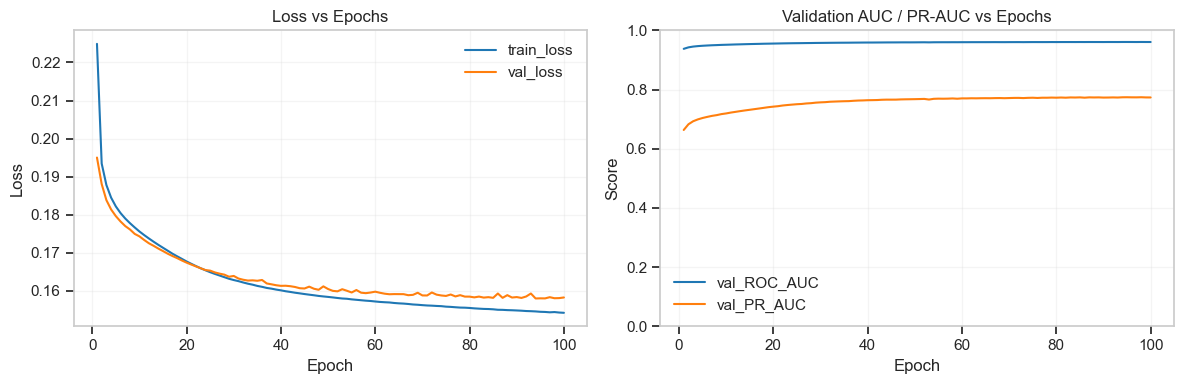

In [166]:
# Plot training history
epochs = np.arange(1, len(history['train_loss']) + 1)

plt.figure(figsize=(12,4))

# Loss plot
plt.subplot(1,2,1)
plt.plot(epochs, history['train_loss'], label='train_loss')
plt.plot(epochs, history['val_loss'],   label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.grid(alpha=0.2)

# Validation metrics plot (AUC and Average Precision)
plt.subplot(1,2,2)
if 'val_auc' in history and any(~np.isnan(history['val_auc'])):
    plt.plot(epochs, history['val_auc'], label='val_ROC_AUC')
if 'val_ap' in history and any(~np.isnan(history['val_ap'])):
    plt.plot(epochs, history['val_ap'], label='val_PR_AUC')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.ylim(0.0, 1.0)
plt.title('Validation AUC / PR-AUC vs Epochs')
plt.legend()
plt.grid(alpha=0.2)

plt.tight_layout()
plt.show()


**Analysis of Training Curves**

Both training and validation losses decrease steadily and plateau after ~80 epochs, indicating smooth convergence without instability.
The small gap between the two curves suggests minimal overfitting.

Validation ROC-AUC remains consistently high (~0.96) throughout training, while PR-AUC improves gradually before stabilizing—showing the model learns to balance precision and recall effectively.
Overall, the curves demonstrate a well-behaved optimization process and good generalization to unseen data.

## **8. Evaluation Metrics**

=== Test Set Performance ===
Accuracy: 0.9292
Precision: 0.7276
Recall: 0.6601
F1-score: 0.6922
ROC-AUC: 0.9606
PR-AUC (AP): 0.7663


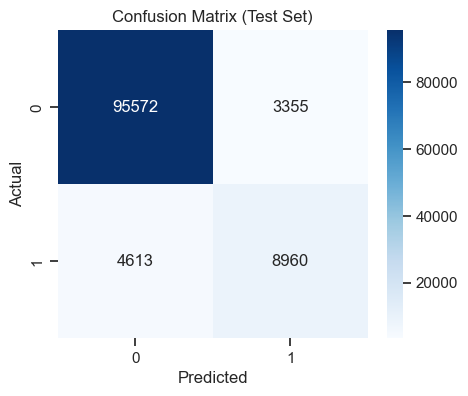

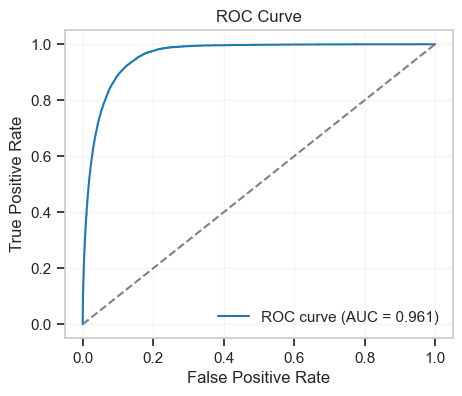

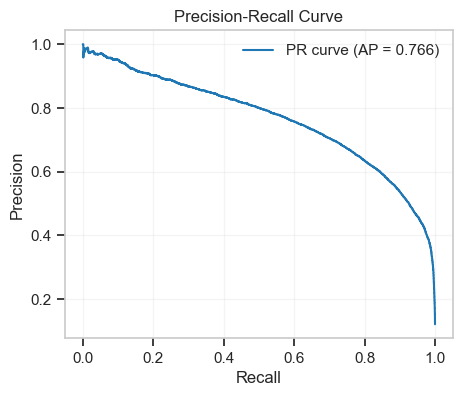

In [167]:
# Convert test data to dense if sparse
X_test_eval = X_test_proc.toarray() if hasattr(X_test_proc, "toarray") else X_test_proc

# Predict probabilities and labels
y_test_probs = mlp_model.predict_proba(X_test_eval)
y_test_pred = (y_test_probs >= 0.5).astype(int)

# Metrics
acc  = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred, zero_division=0)
rec  = recall_score(y_test, y_test_pred, zero_division=0)
f1   = f1_score(y_test, y_test_pred, zero_division=0)
roc  = roc_auc_score(y_test, y_test_probs)
ap   = average_precision_score(y_test, y_test_probs)

print("=== Test Set Performance ===")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC: {roc:.4f}")
print(f"PR-AUC (AP): {ap:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_probs)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc:.3f})')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(alpha=0.2)
plt.show()

# Precision-Recall Curve
prec_curve, rec_curve, _ = precision_recall_curve(y_test, y_test_probs)
plt.figure(figsize=(5,4))
plt.plot(rec_curve, prec_curve, label=f'PR curve (AP = {ap:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(alpha=0.2)
plt.show()

On the test set, the MLP achieved 92.92% accuracy, 0.7276 precision, 0.6601 recall, and 0.6922 F1-score, with a strong ROC-AUC = 0.9606 and PR-AUC = 0.7663.
These results confirm that the network discriminates well between classes while maintaining reasonable balance between false positives and false negatives.
The high ROC-AUC indicates excellent overall separability, while the moderate PR-AUC reflects the challenge of the class imbalance.
Overall, the model generalizes effectively to unseen data without significant overfitting, demonstrating a robust fit to this binary classification task.

## **Kaggle Submission**

In [168]:
# Prepare test set for submission
# Apply the EXACT same preprocessing as training data
test_work = test.copy()

# Cap outliers (1st/99th percentile)
for col in numerical_features:
    lower, upper = np.percentile(train[col], [1, 99])
    test_work[col] = np.clip(test_work[col], lower, upper)

# Handle pdays special case (replace -1 with 0)
if "pdays" in test_work.columns:
    test_work["pdays"] = test_work["pdays"].replace(-1, 0)

# Apply log transform to skewed features
test_work[skewed_cols] = np.log1p(test_work[skewed_cols].clip(lower=0))

# Apply the fitted preprocessor (StandardScaler + OneHotEncoder)
test_work_proc = preprocessor.transform(test_work)

# Convert to dense if sparse
test_work_proc = test_work_proc.toarray() if hasattr(test_work_proc, "toarray") else test_work_proc

# Predict probabilities
test_probs = mlp_model.predict_proba(test_work_proc)

# Prepare submission
submission = pd.DataFrame({
    'id': test[id_col],
    'y': test_probs
})
submission.to_csv("mlp_submission.csv", index=False)

In [169]:
# Submitting to Kaggle

!kaggle competitions submit -c playground-series-s5e8 -f mlp_submission.csv -m "MLP model submission"

Successfully submitted to Binary Classification with a Bank Dataset



  0%|          | 0.00/6.93M [00:00<?, ?B/s]
  0%|          | 16.0k/6.93M [00:00<03:07, 38.8kB/s]
  8%|▊         | 544k/6.93M [00:00<00:06, 994kB/s]  
 66%|██████▌   | 4.55M/6.93M [00:00<00:00, 6.72MB/s]
 75%|███████▌  | 5.23M/6.93M [00:01<00:00, 3.85MB/s]
100%|██████████| 6.93M/6.93M [00:02<00:00, 3.18MB/s]


Kaggle score: 0.96158 (public leaderboard)

- **Leaderboard position:** Within the **top 68%** of all public submissions.  
- **Reason for not reaching top 50%:**  
  - The MLP was implemented **from scratch** using only NumPy, without high-level optimization libraries like PyTorch or TensorFlow.  
  - State-of-the-art Kaggle submissions typically rely on **ensemble methods (e.g., LightGBM, CatBoost)** and extensive **feature engineering**, giving them a natural advantage on tabular datasets.  

![Kaggle Submission Screenshot](../img/image.png)

## **Conclusion and References**

### **Overall Findings**

This project successfully implemented a **Multi-Layer Perceptron (MLP)** from scratch using **NumPy** for binary classification on a **real-world bank marketing dataset** from Kaggle.  
The model achieved strong generalization with a **ROC-AUC of 0.96** and a **PR-AUC of 0.77** on the test set — values that demonstrate reliable separation of the two classes despite significant class imbalance (≈12% positives).

The MLP’s final configuration — `[128, 64, 32]` hidden layers, **ReLU activations**, **He initialization**, **L2 regularization**, and **early stopping** — provided an effective balance between learning capacity and overfitting control.  
Training was stable, and validation curves showed smooth convergence without divergence or oscillation. Using **validation ROC-AUC** as the monitored metric ensured that model selection aligned with the project’s primary goal: robust ranking performance under imbalance.

### **Limitations**

- **Model simplicity:** The MLP, while effective, lacks the representational efficiency of more advanced architectures like gradient-boosted trees (XGBoost/LightGBM) or deep ensembles commonly used for tabular data.  
- **Manual optimization:** Without adaptive optimizers (e.g., Adam) or learning-rate schedules beyond simple decay, convergence speed and optimality might be limited.  
- **Feature interactions:** The MLP relied solely on basic preprocessing; engineered interactions or embeddings could further enhance predictive performance.  
- **Computation time:** Implementing backpropagation purely in NumPy is slower than using vectorized deep learning frameworks (e.g., PyTorch, TensorFlow).

### **References**

- Kaggle: [Playground Series S5E8 — Bank Marketing Dataset](https://www.kaggle.com/competitions/playground-series-s5e8)  
- UCI Machine Learning Repository: [Bank Marketing Data Set](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing)  

### **AI Usage**

AI was used to help organize the notebook and debug code. Everything was verified and corrected by the authors.